In [1]:
%matplotlib inline
#%matplotlib notebook

In [2]:
import cytoflow as flow
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
matplotlib.rc('figure', dpi = 160)

# Import samples and specify experimental condtions

In [3]:
inputs = [
    ["Experiment_Tube_001_001.fcs",0,0],
    ["Experiment_Tube_002_002.fcs",1e-12, 0],
    ["Experiment_Tube_003_003.fcs",1e-10, 0],
    ["Experiment_Tube_004_004.fcs",1e-8, 0],
    ["Experiment_Tube_005_005.fcs",1e-6, 0],
    ["Experiment_Tube_006_006.fcs",1e-4, 0],
    ["Experiment_Tube_008_008.fcs",0,2e-4],
    ["Experiment_Tube_009_009.fcs",1e-12, 2e-4],
    ["Experiment_Tube_010_010.fcs",1e-10, 2e-4],
    ["Experiment_Tube_011_011.fcs",1e-8, 2e-4],
    ["Experiment_Tube_012_012.fcs",1e-6, 2e-4],
    ["Experiment_Tube_013_013.fcs",1e-4, 2e-4],
    ["Experiment_Tube_015_015.fcs",0,1e-3],
    ["Experiment_Tube_016_016.fcs",1e-12, 1e-3],
    ["Experiment_Tube_017_017.fcs",1e-10, 1e-3],
    ["Experiment_Tube_018_018.fcs",1e-8, 1e-3],
    ["Experiment_Tube_019_019.fcs",1e-6, 1e-3],
    ["Experiment_Tube_020_020.fcs",1e-4, 1e-3],
]
in2 = [["Experiment_Tube_014_014.fcs",10],
       ["Experiment_Tube_021_021.fcs",20],
       ["Experiment_Tube_006_006.fcs",30]
]
       
tubes = []
for filename, ahl, iptg in inputs:
    tubes.append(flow.Tube(file = 'data/' + filename, conditions = {'AHL' : ahl, 'IPTG' : iptg}))
    
ex = flow.ImportOp(conditions = {'AHL' : 'float', 'IPTG' : 'float'},
                   tubes = tubes).apply()
       
tubes2 = []
for filename, time in in2:
    tubes2.append(flow.Tube(file = 'data/' + filename, conditions = {'Minutes' : time}))
    
ex2 = flow.ImportOp(conditions = {'Minutes' : 'int'},
                   tubes = tubes2).apply()

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10


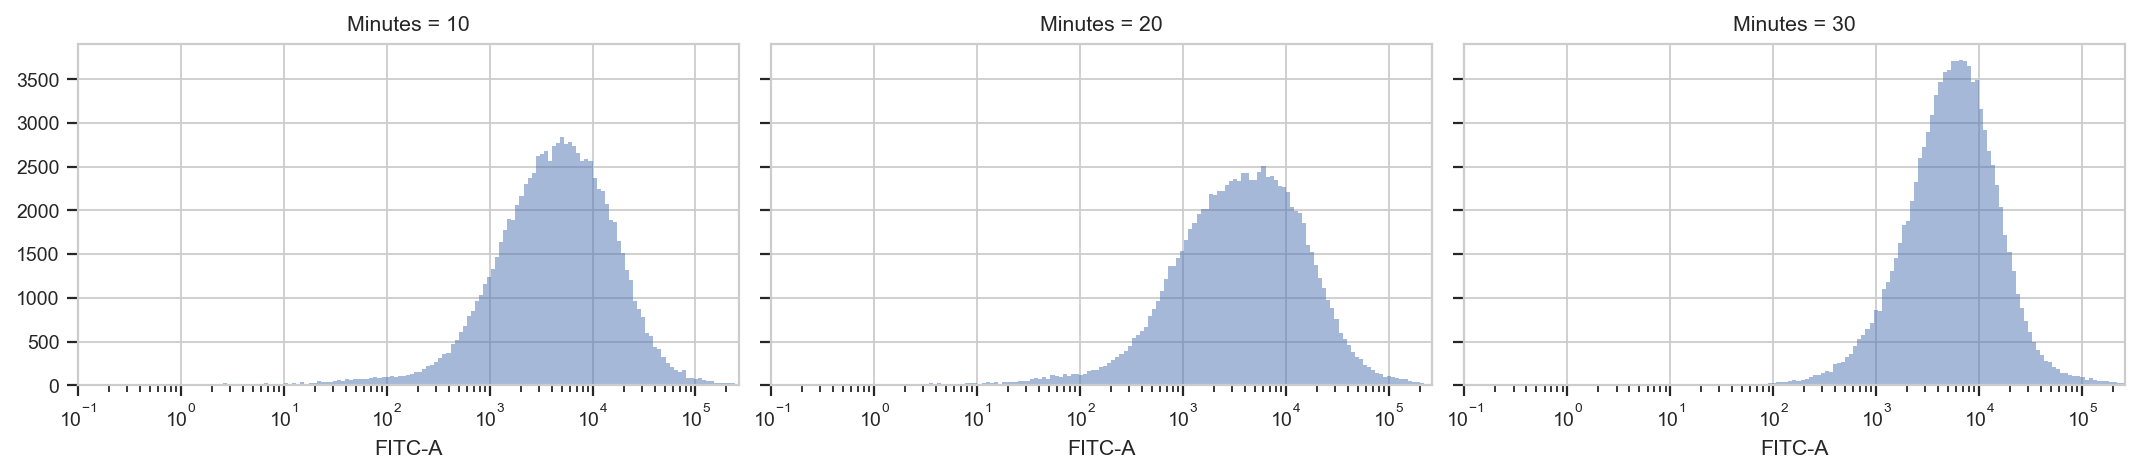

In [4]:
flow.HistogramView(channel = "FITC-A",
                   xfacet = "Minutes",scale='log').plot(ex2)

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


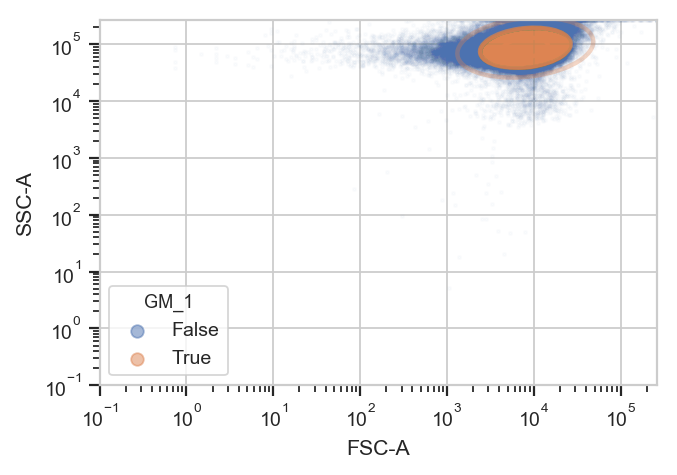

In [5]:
gm2 = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm2.estimate(ex2)
ex_gm2 = gm2.apply(ex2)
gm2.default_view().plot(ex_gm2, alpha = 0.02)

## Effect of fixation time on mNG intensity

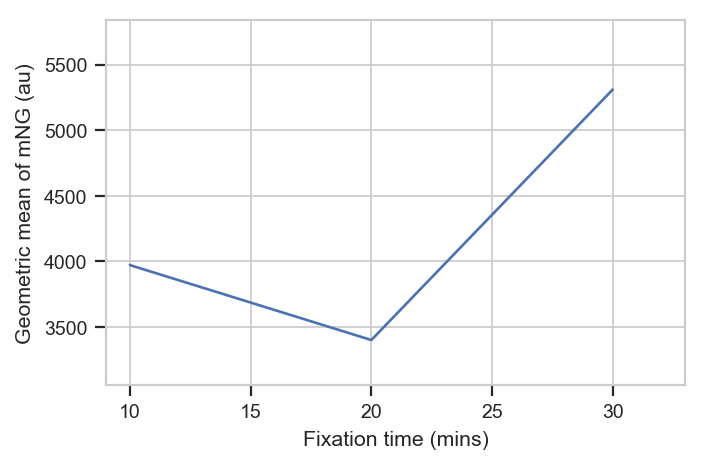

In [6]:
ex3 = flow.ChannelStatisticOp(name = "ByMins",
                              channel = "FITC-A",
                              by = ["Minutes"],
                              function = flow.geom_mean).apply(ex_gm2)
flow.Stats1DView(statistic = ("ByMins", "geom_mean"),
                 scale = "linear",
                 variable = "Minutes",
                 variable_scale = "linear").plot(ex3,ylabel = 'Geometric mean of mNG (au)',xlabel ='Fixation time (mins)')

In [7]:
flow.set_default_scale("log")

# Plot FITC-A histograms for all IPTG and AHL induction conditions

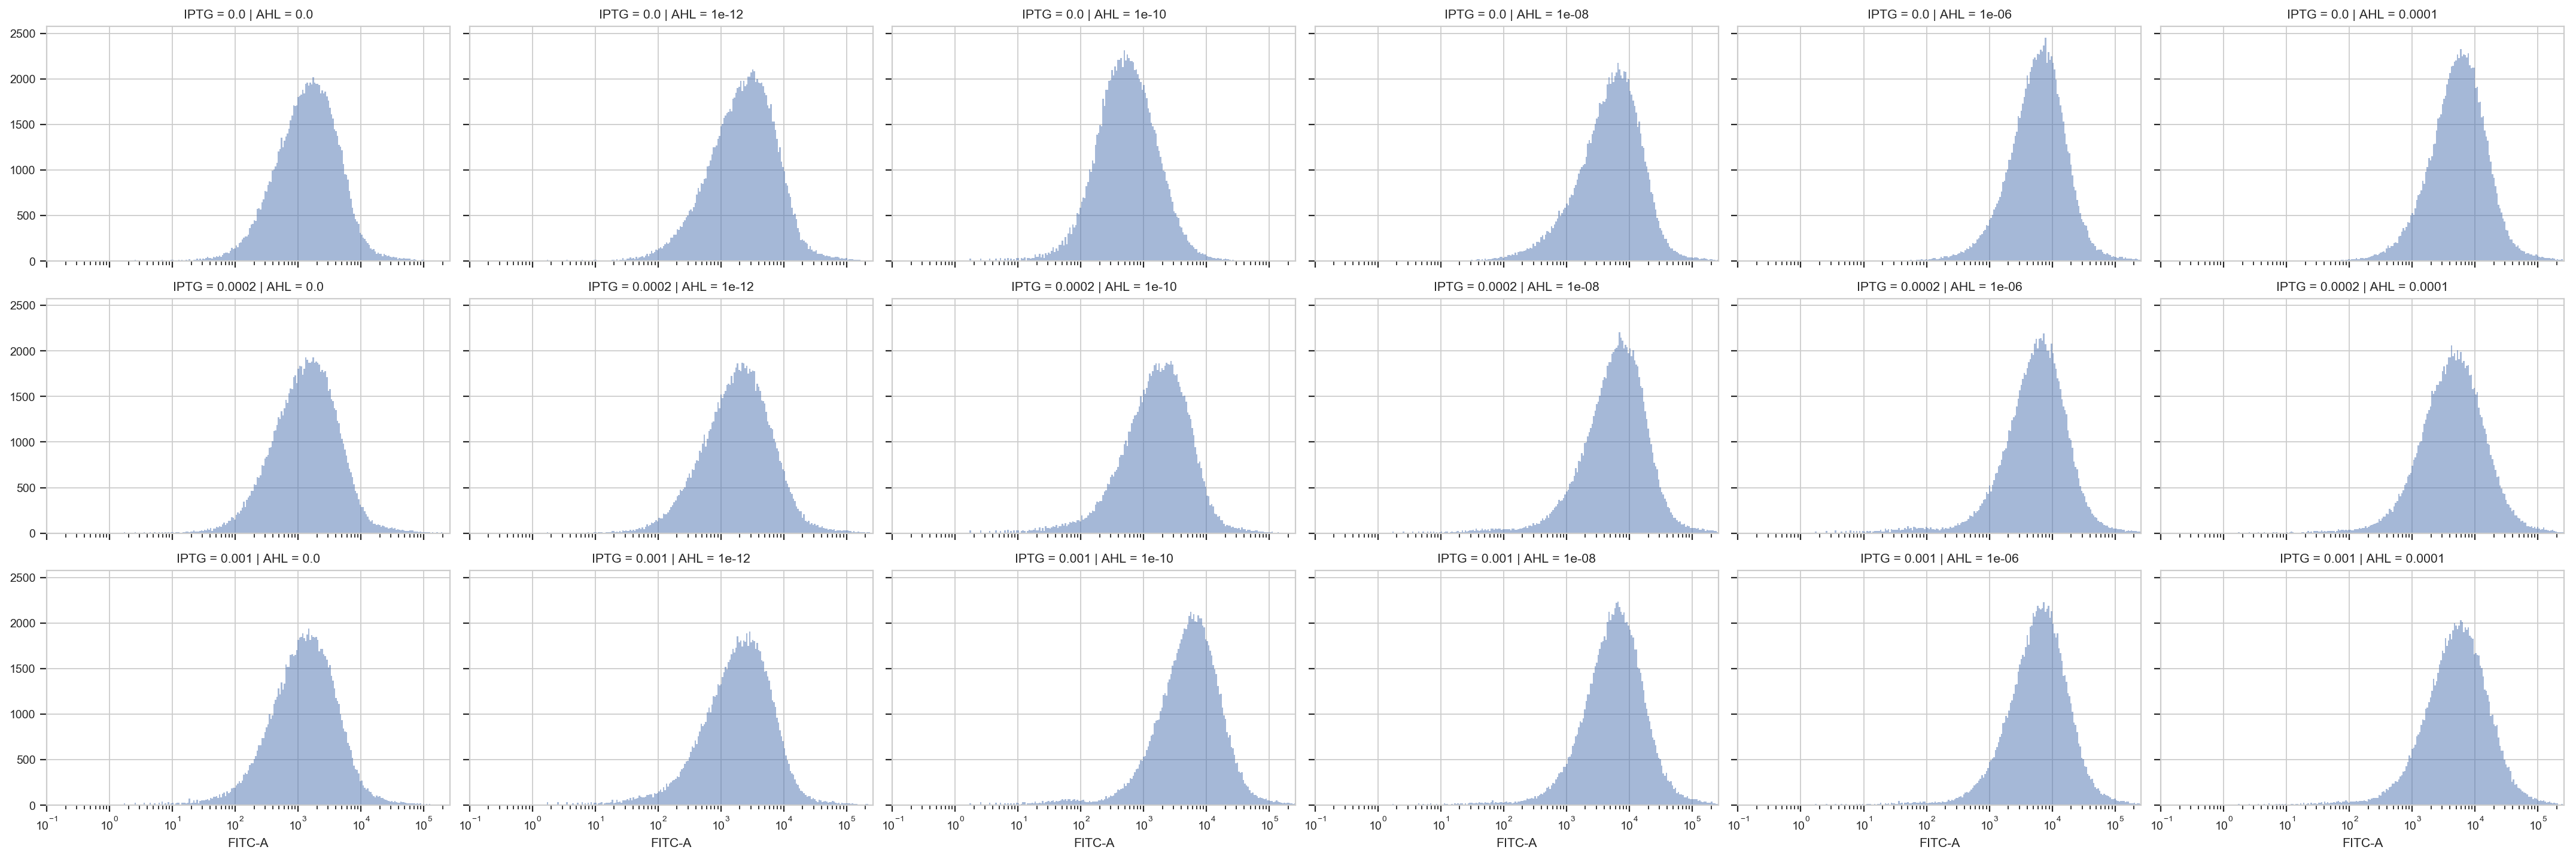

In [8]:

flow.HistogramView(channel = "FITC-A",
                   xfacet = "AHL",
                  yfacet = 'IPTG').plot(ex)

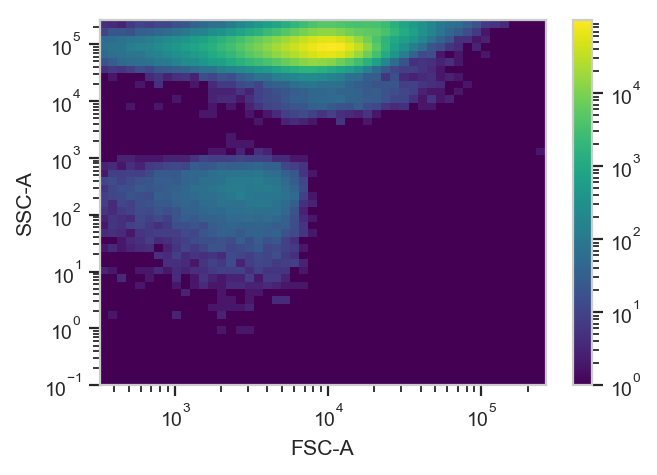

In [9]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

# Singlet gating to remove doublets

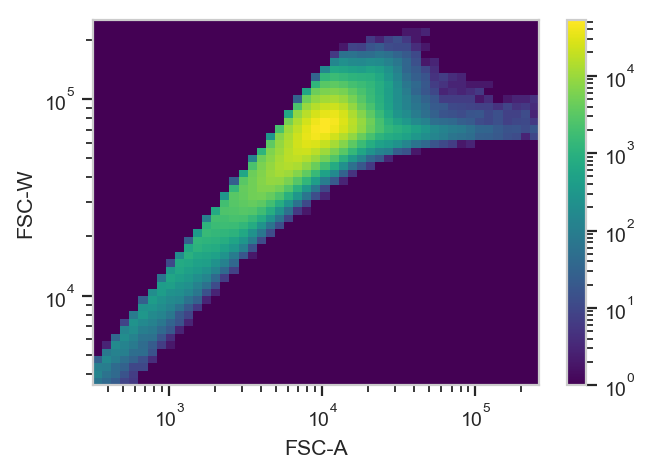

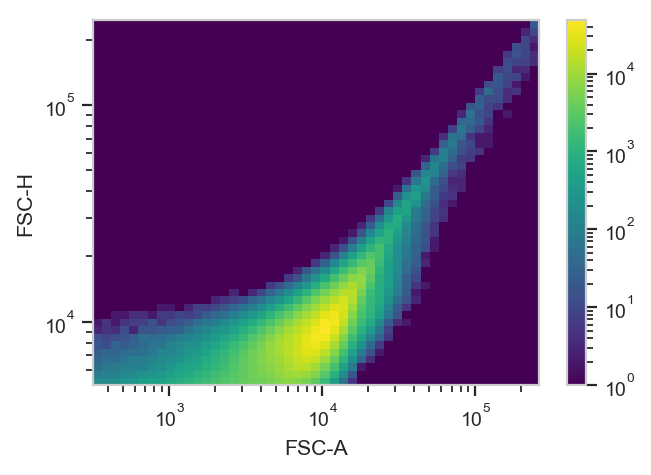

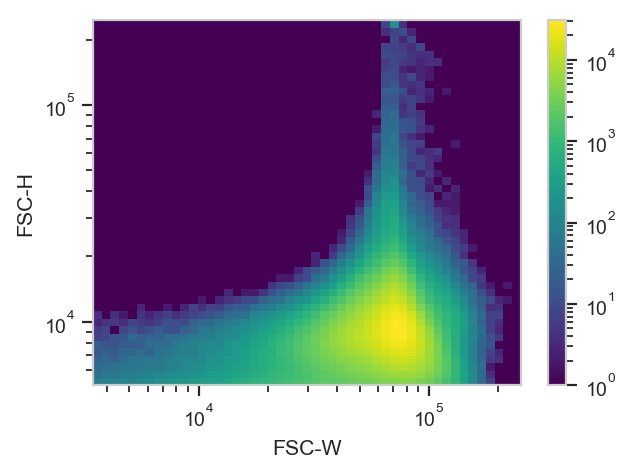

In [10]:

#channels = ['FSC-A','FSC-W','FSC-H','SSC-A','SSC-W','SSC-H']
#perm = combinations(channels,2)
FSC = [('FSC-A','FSC-W'),('FSC-A','FSC-H'),('FSC-W','FSC-H')]

#f, axes = plt.subplots(ncols=4,nrows=4)
#axs = axes.ravel()
for i,(x,y) in enumerate(FSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'log',
                yscale = 'log').plot(ex, min_quantile = 0.005)


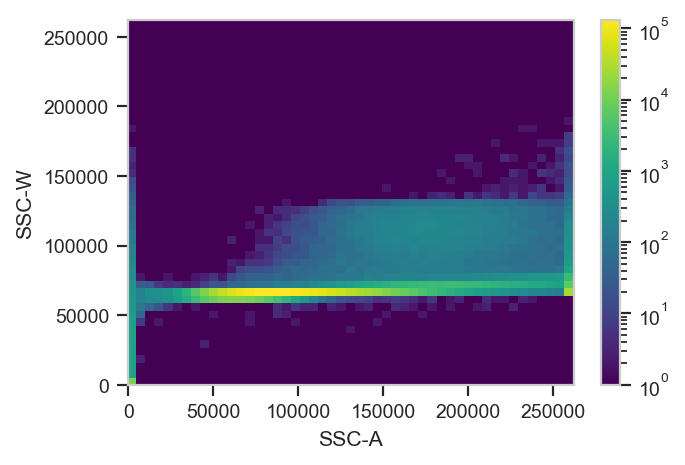

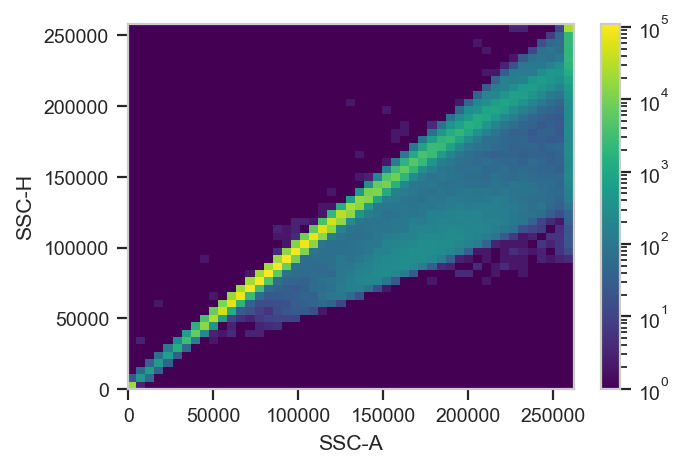

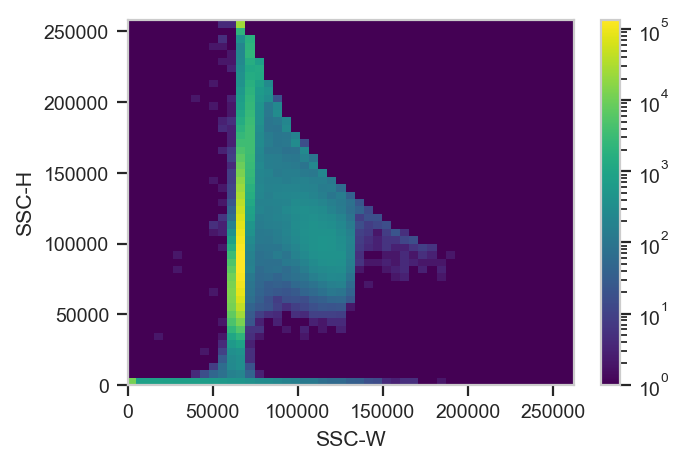

In [11]:
SSC = [('SSC-A','SSC-W'),('SSC-A','SSC-H'),('SSC-W','SSC-H')]
for i,(x,y) in enumerate(SSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'linear',
                yscale = 'linear').plot(ex, min_quantile = 0.005)

## Create and store singlet gate

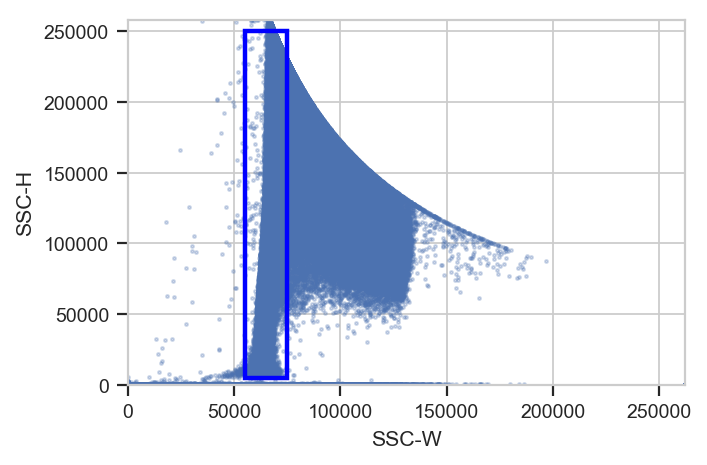

In [12]:
r = flow.Range2DOp(name = "Range2D",
                   xchannel = "SSC-W",
                   xlow = 55000,
                   xhigh = 75000,
                   ychannel = "SSC-H",
                   ylow = 5000,
                   yhigh = 250000)
                   
rv = r.default_view(xscale ='linear',yscale='linear')

rv.plot(ex)
ex2 = r.apply(ex)

## Use a gaussian mixture model to further gate the population

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


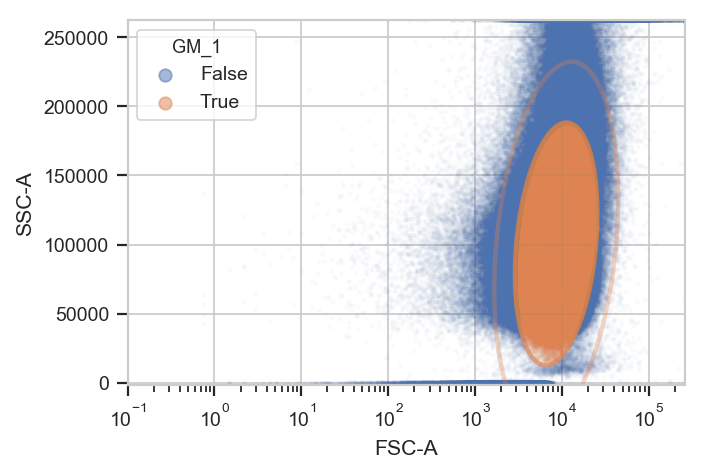

In [13]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'linear'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex2)
ex_gm = gm.apply(ex2)
gm.default_view().plot(ex_gm, alpha = 0.02)

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM3_1'


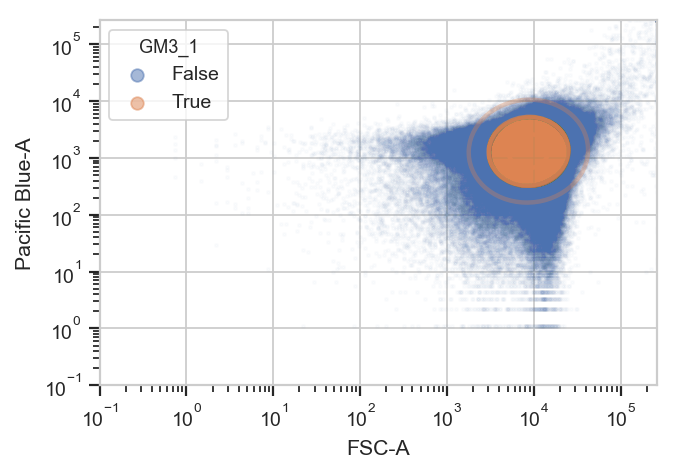

In [14]:
gm3 = flow.GaussianMixtureOp(name = "GM3",
                            channels = ['FSC-A', 'Pacific Blue-A'],
                            scale = {'FSC-A' : 'log',
                                     'Pacific Blue-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm3.estimate(ex_gm)
ex_gm2 = gm3.apply(ex_gm)
gm3.default_view().plot(ex_gm2, alpha = 0.02)

In [15]:
df =ex_gm2.data

# filter out events that don't fall within the gates

In [16]:

df = df[(df.GM_1==True) & (df.GM3_1==True) & (df.Range2D==True) & (df['FITC-A'] >0)]
df

,AHL,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,IPTG,Pacific Blue-A,Pacific Blue-H,Pacific Blue-W,SSC-A,SSC-H,SSC-W,Time,Range2D,GM_1,GM3_1
0,0.0000,5773.319824,5766.0,65619.203125,8096.430176,9266.0,57263.937500,0.000,1954.700073,1653.0,77497.414062,102167.578125,100614.0,66547.937500,53.099998,True,True,True
1,0.0000,1035.300049,1131.0,59990.652344,13059.700195,13871.0,61702.867188,0.000,994.400024,650.0,100260.015625,108743.914062,106415.0,66970.273438,53.099998,True,True,True
2,0.0000,2589.989990,2420.0,70139.500000,6653.220215,6560.0,66467.289062,0.000,1565.300049,1692.0,60628.550781,104398.257812,98516.0,69449.070312,53.099998,True,True,True
3,0.0000,425.429993,281.0,99220.570312,7518.270020,7437.0,66252.164062,0.000,616.000000,970.0,41618.742188,53448.449219,52477.0,66749.195312,53.200001,True,True,True
5,0.0000,7032.209961,6421.0,71774.320312,7258.390137,6193.0,76810.250000,0.000,1705.000000,1524.0,73319.476562,132616.703125,126469.0,68721.726562,53.200001,True,True,True
6,0.0000,487.200012,576.0,55432.539062,10477.690430,9049.0,75883.085938,0.000,861.300049,900.0,62717.957031,77681.429688,78426.0,64913.804688,53.200001,True,True,True
7,0.0000,1143.180054,1100.0,68108.593750,8209.580078,7800.0,68977.320312,0.000,1551.000000,1609.0,63173.609375,113285.312500,111016.0,66875.640625,53.299999,True,True,True
8,0.0000,1954.020020,1952.0,65603.828125,11942.070312,11652.0,67167.484375,0.000,1321.099976,1580.0,54797.218750,99311.367188,97892.0,66486.234375,53.299999,True,True,True
9,0.0000,3437.370117,3758.0,59944.515625,10017.060547,8682.0,75613.695312,0.000,1667.599976,1541.0,70920.070312,90034.562500,90958.0,64870.652344,53.299999,True,True,True
10,0.0000,3935.880127,3738.0,69005.304688,9544.020508,9294.0,67299.000000,0.000,1606.000000,1841.0,57170.464844,98933.789062,97434.0,66544.789062,53.299999,True,True,True


In [17]:
import scipy.stats as stats
import scipy as sp
from scipy.stats.mstats import gmean
import numpy as np

def geom_sd(a):
    a = np.array(a)
    u = gmean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
    
    return np.exp(np.std(np.log(a)))
def geom_sem(a):
    a = np.array(a)
    u = geom_mean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
def geom_std(values):
    """
    Calculates the geometric standard deviation for the passed values.
    Source: https://en.wikipedia.org/wiki/Geometric_standard_deviation
    """

   # gmean = stats.gmean(values)
    return sp.exp(sp.sqrt(sp.sum([sp.log(x / gmean(values)) ** 2 for x in values]) / len(values))) 


# Plot mean FITC-A

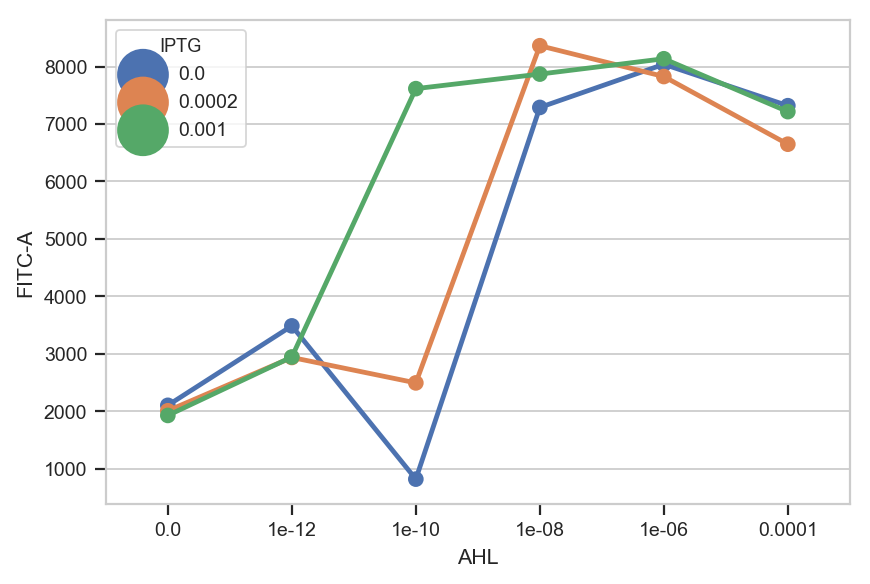

In [18]:
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',data=df)

In [19]:
gb = df.groupby(['AHL','IPTG'])
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
geostd = df.groupby(['AHL','IPTG'])['FITC-A'].apply(geom_sd).reset_index()

std = df.groupby(['AHL','IPTG'])['FITC-A'].std().reset_index()


# Plot Geometric mean FITC-A

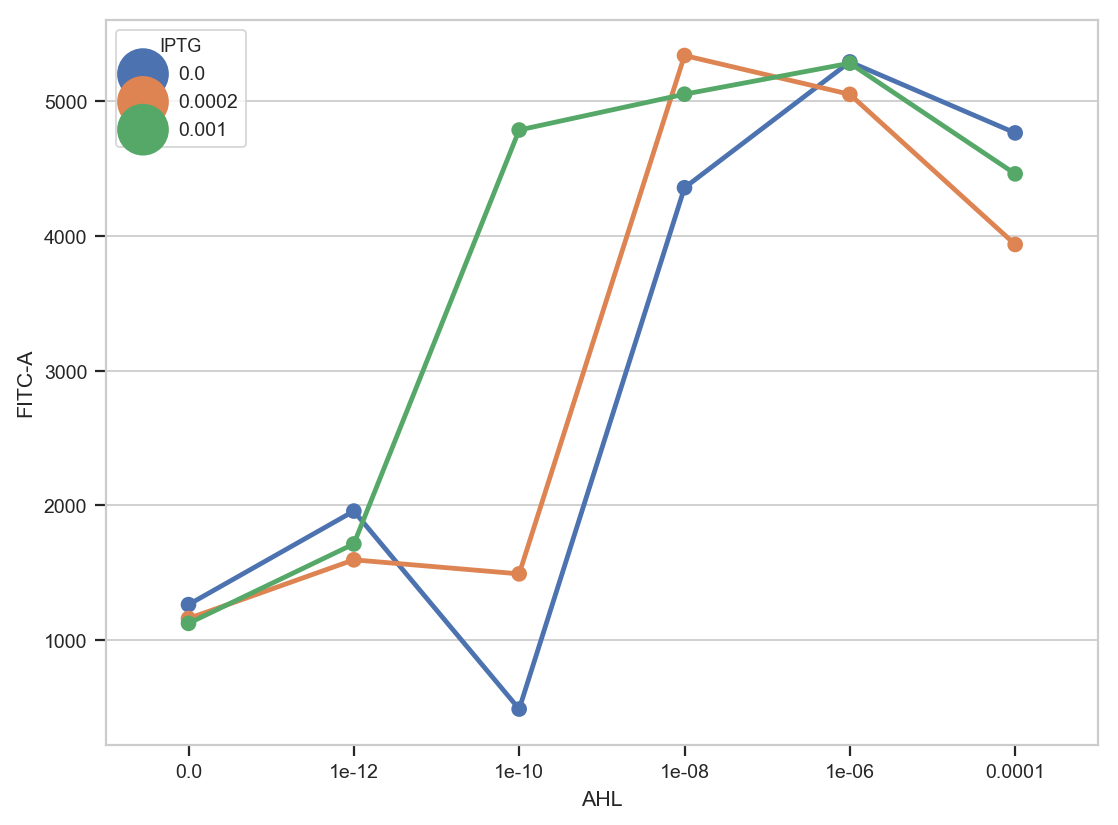

In [20]:
f, ax = plt.subplots(figsize=(8,6))
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',estimator=gmean,ci=0.01,data=df)
f.savefig('Lux.png',dpi=600)

In [21]:
mean

,AHL,IPTG,FITC-A
0,0.000000e+00,0.0000,1261.982254
1,0.000000e+00,0.0002,1158.732508
2,0.000000e+00,0.0010,1122.966710
3,1.000000e-12,0.0000,1956.619018
4,1.000000e-12,0.0002,1594.655977
5,1.000000e-12,0.0010,1712.547283
6,1.000000e-10,0.0000,486.490760
7,1.000000e-10,0.0002,1490.382747
8,1.000000e-10,0.0010,4786.269699
9,1.000000e-08,0.0000,4357.732341


# Calculate standard deviation percentages

In [22]:
std['FITC-A']/mean['FITC-A']*100

0     189.176734
1     210.483792
2     208.547080
3     208.278463
4     230.105828
5     190.780249
6     212.376988
7     180.898446
8     165.481079
9     173.539109
10    152.630503
11    159.959854
12    153.577651
13    156.954393
14    153.881482
15    162.918523
16    200.760243
17    174.536410
Name: FITC-A, dtype: float64

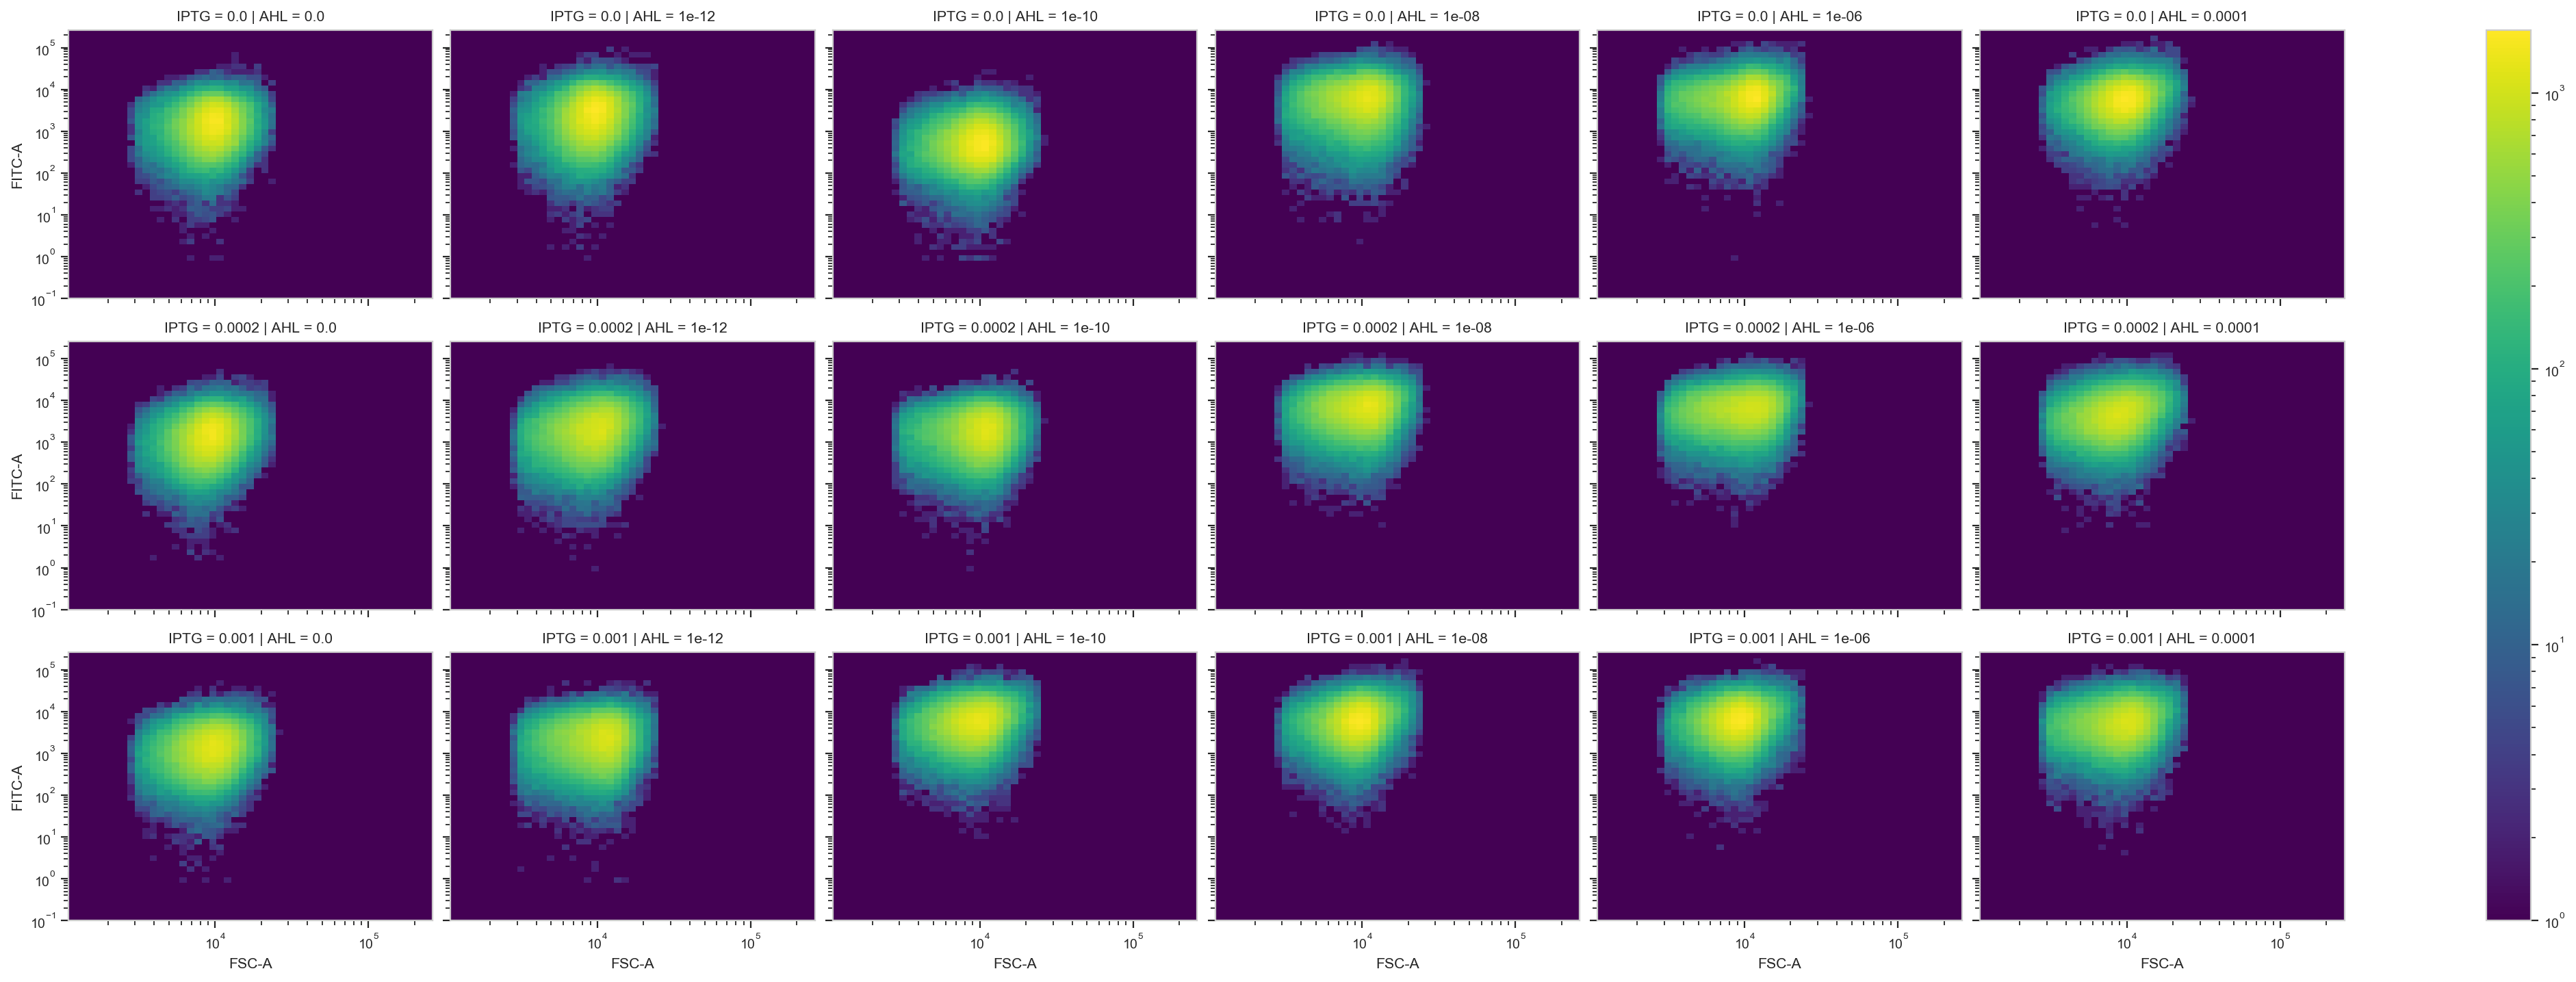

In [23]:

flow.DensityView(xchannel = 'FSC-A', 
                ychannel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'GM_1 == True').plot(ex_gm2, min_quantile = 0.01)

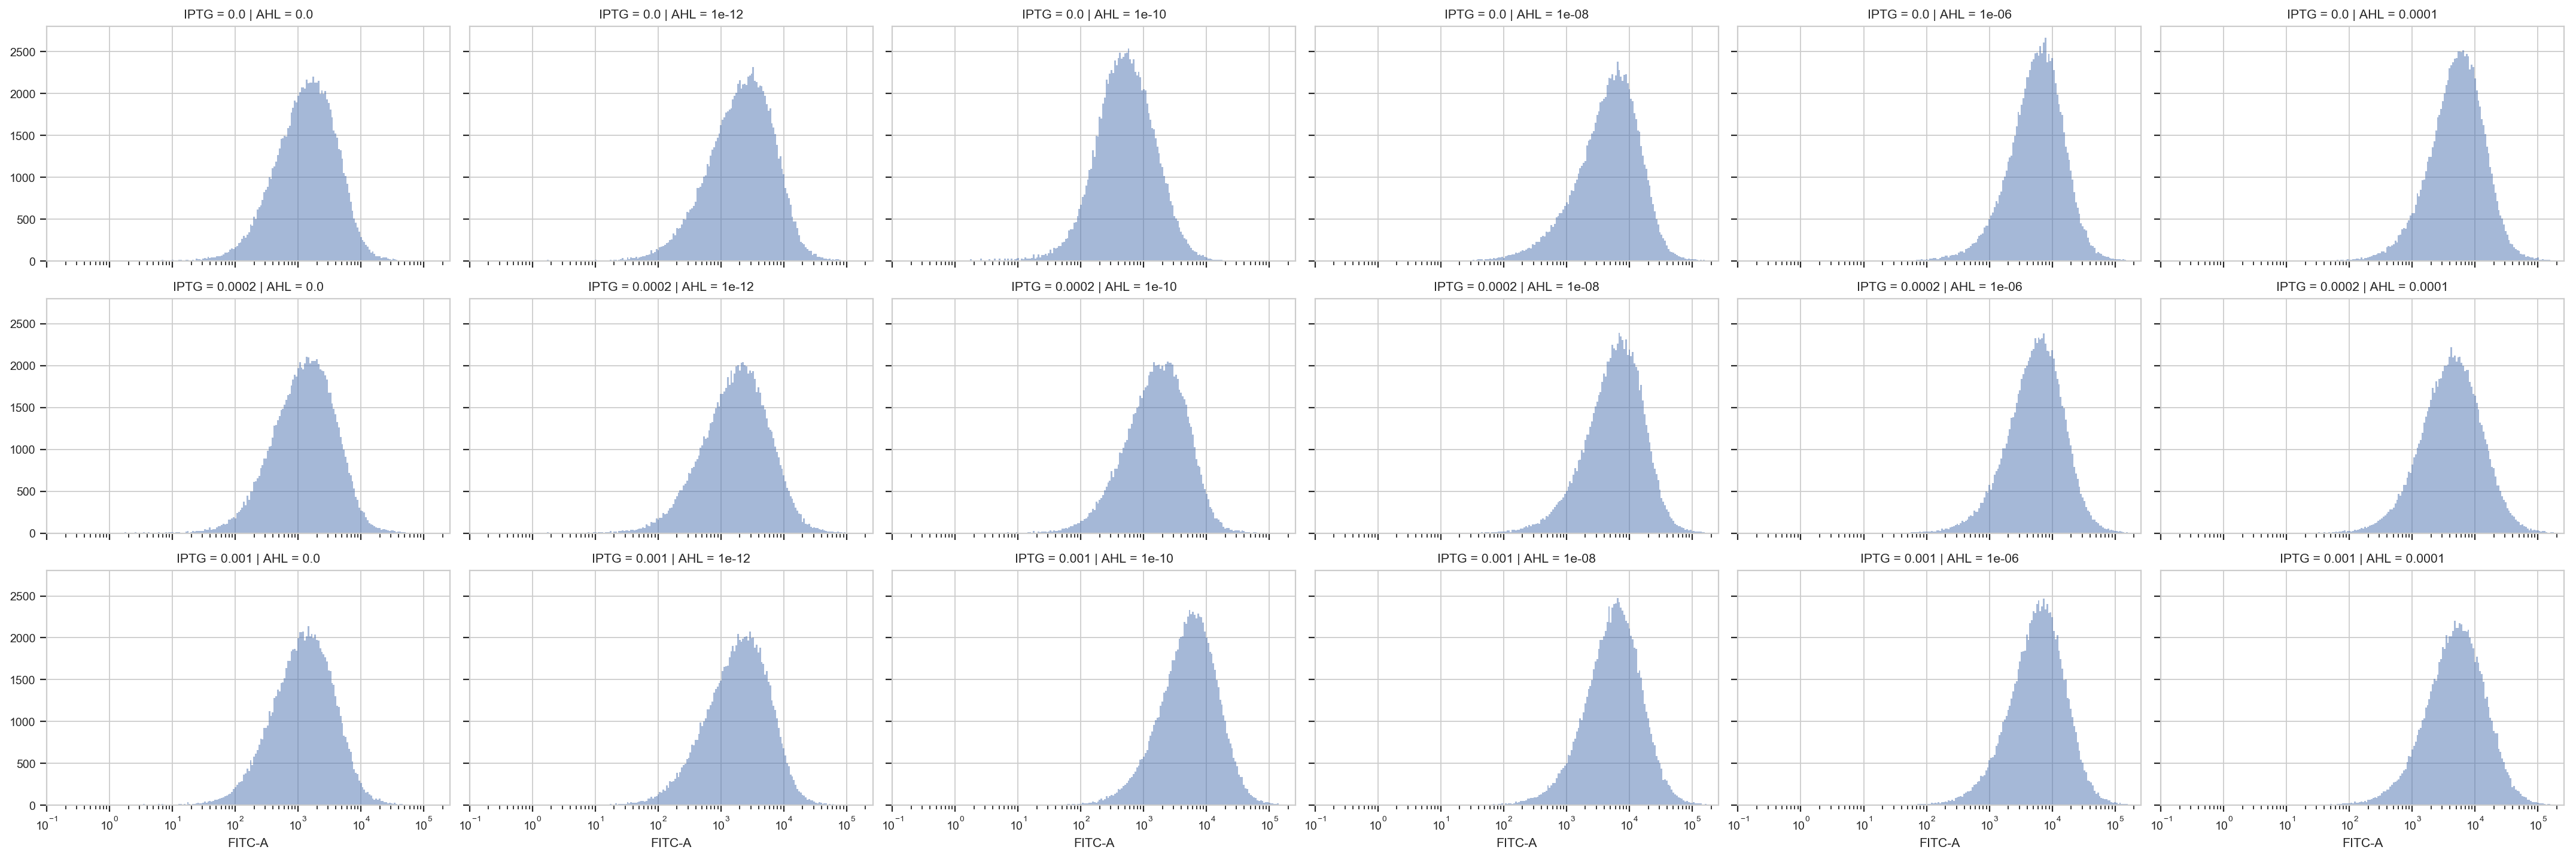

In [24]:
flow.HistogramView(channel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'Range2D == True').plot(ex_gm2, min_quantile = 0.01)

# Plot heatmaps showing absolute and relative induction

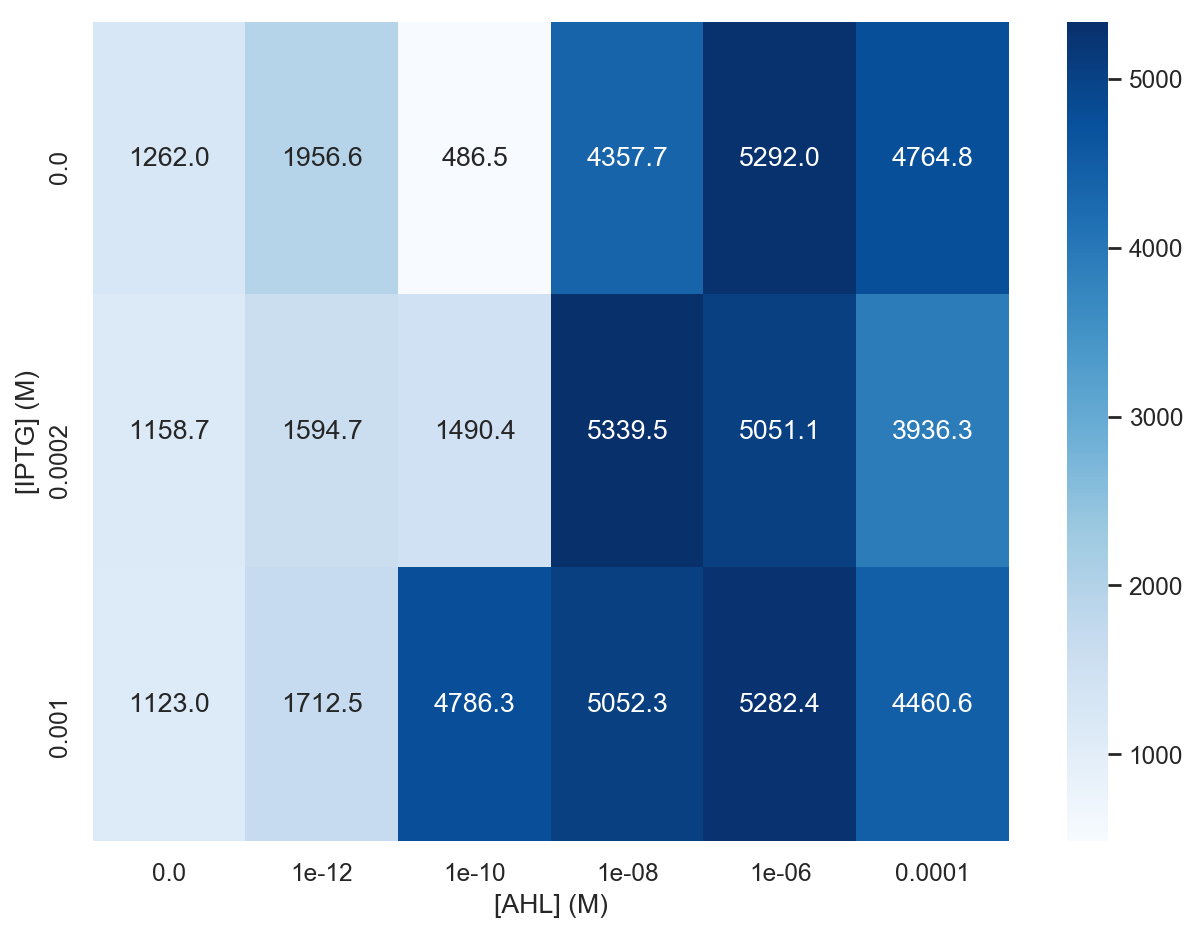

In [25]:
#LasMeans = Las.groupby(['C_ahl','C_iptg']).mean().reset_index()
sns.set(style="white")
#sns.set_style('Talk')
#LasTable = pd.pivot_table(LasMeans,values='FITC-A',index='C_iptg',columns='C_ahl')
f, ax = plt.subplots(figsize=(8,6))
#g = sns.heatmap(LasTable,vmin=0,vmax=100,xticklabels=[0,1e-10,1e-9,1e-7],yticklabels=[0,1e-3,1e-4,1e-5],ax=ax,square=True,cmap='Reds')



#f.savefig('LasHeatmap.png',dpi=600)
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
#mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
#cbar.set_ticks([0, 25, 50, 75,100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

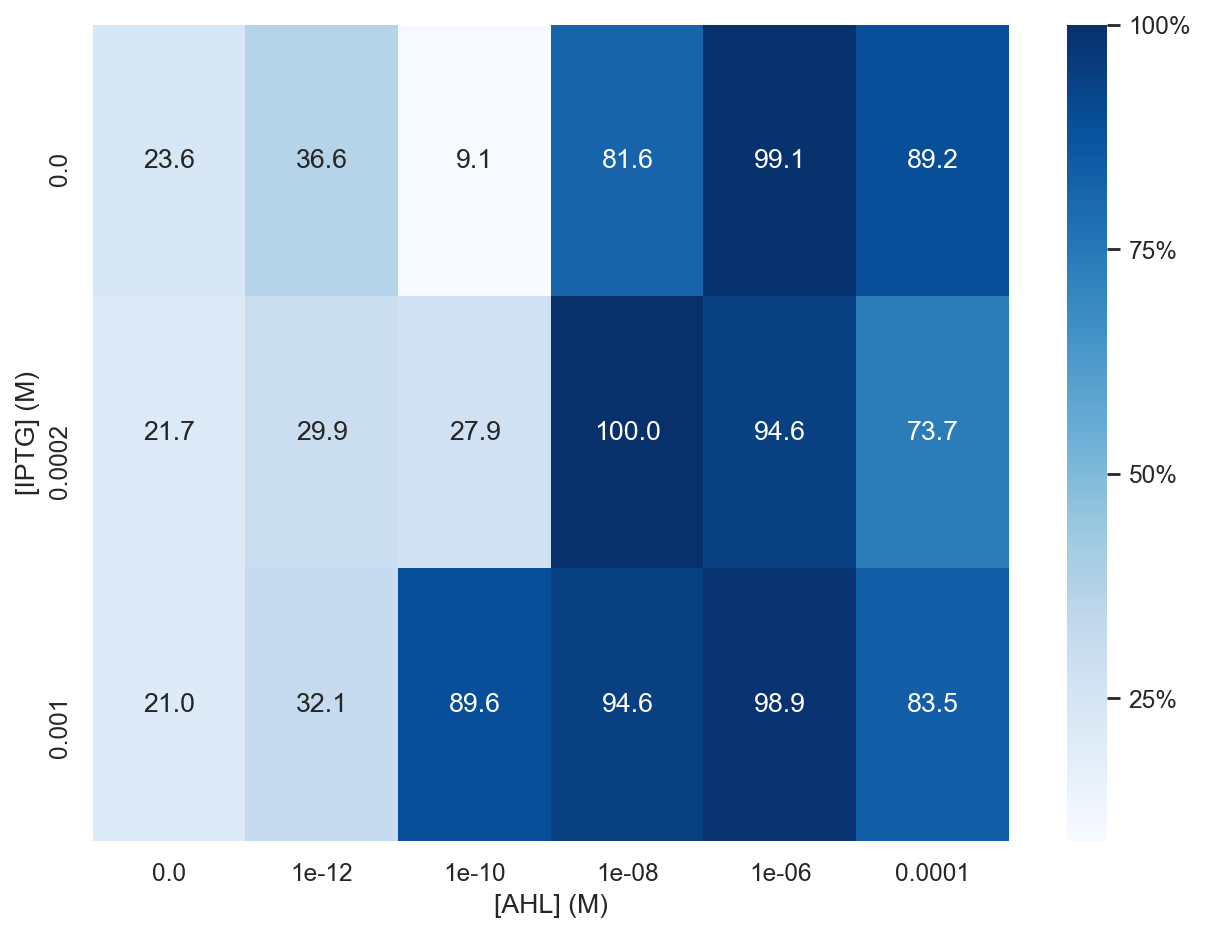

In [26]:
f, ax = plt.subplots(figsize=(8,6))
# normalized
mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

# Calculate the on/off ratio and plot

In [27]:

R =[]
for i in mean.IPTG.unique():
    tmp = mean[mean.IPTG ==i]['FITC-A'].max()/mean[mean.IPTG ==i]['FITC-A'].min()
    R.append([i,tmp])



In [28]:

R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])
R

,IPTG,Induction Ratio
0,0.0000,10.877965
1,0.0002,4.608073
2,0.0010,4.703942


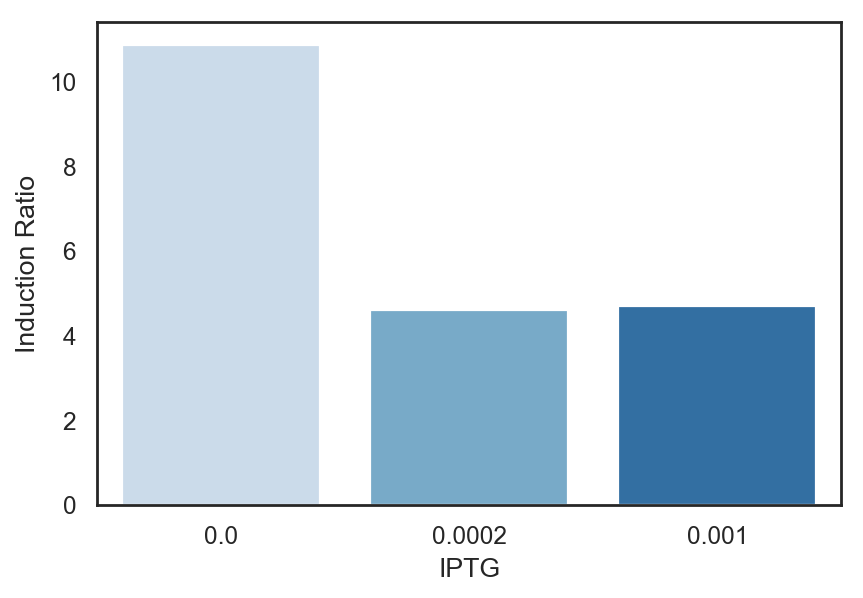

In [29]:
f, ax  = plt.subplots()
sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues')

# Fit data to logistic function

In [30]:
import scipy.optimize as opt
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
data = mean.copy()
data.AHL[data.AHL == 0]=1e-14


In [31]:
data

,AHL,IPTG,FITC-A
0,1.000000e-14,0.0000,1261.982254
1,1.000000e-14,0.0002,1158.732508
2,1.000000e-14,0.0010,1122.966710
3,1.000000e-12,0.0000,1956.619018
4,1.000000e-12,0.0002,1594.655977
5,1.000000e-12,0.0010,1712.547283
6,1.000000e-10,0.0000,486.490760
7,1.000000e-10,0.0002,1490.382747
8,1.000000e-10,0.0010,4786.269699
9,1.000000e-08,0.0000,4357.732341


C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated


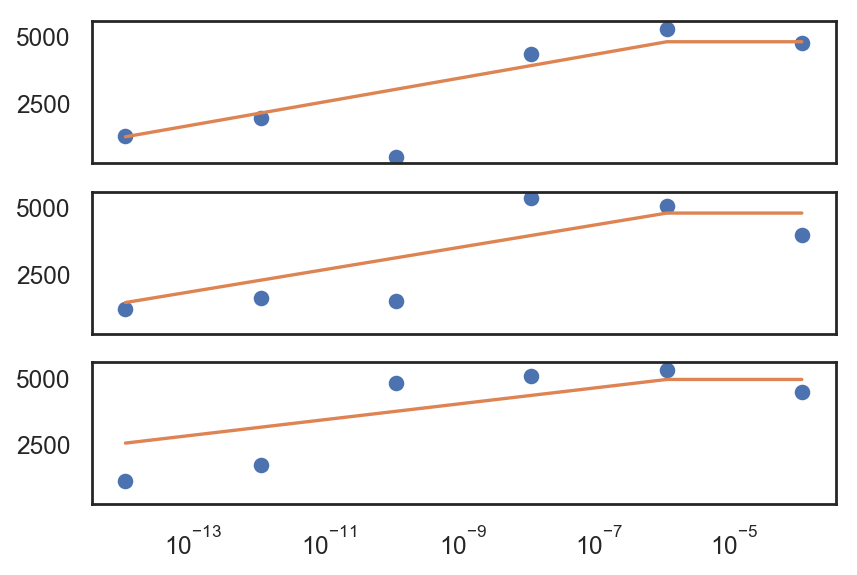

In [32]:
def f(x, a, b, c, d):
    return (a -b) / (1 + np.exp(c * (np.log10(d)-np.log10(x)))) + b
fig, axes = plt.subplots(3, 1, figsize=(6, 4),sharex=True,sharey=True)
axs = axes.ravel()
for i,iptg in enumerate(data.IPTG.unique()):
    tmp = data[data.IPTG==iptg]
    (a_, b_, c_, d_), _ = opt.curve_fit(f, tmp.AHL, tmp['FITC-A'],p0=[5e3,1e2,1e2,1e-9],maxfev=10000000)
    n = 100
    x = np.linspace(tmp.AHL.min(), tmp.AHL.max(), n)

    y_fit = f(x, a_, b_, c_, d_)

    
    axs[i].plot(tmp.AHL.values, tmp['FITC-A'].values, 'o')
    axs[i].plot(x, y_fit, '-')
    plt.xscale('log')
plt.show()

In [33]:
tmp.AHL

2     1.000000e-14
5     1.000000e-12
8     1.000000e-10
11    1.000000e-08
14    1.000000e-06
17    1.000000e-04
Name: AHL, dtype: float64

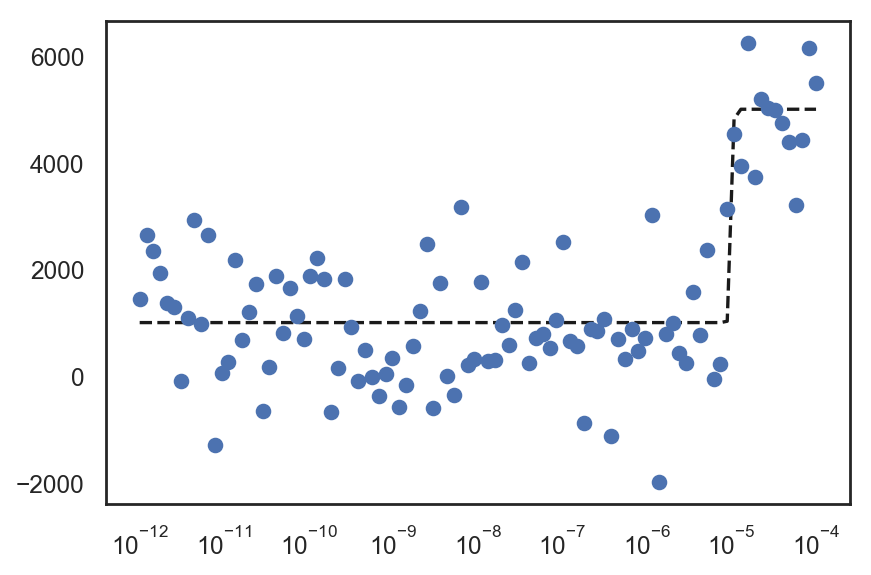

In [34]:
#a, c = np.random.exponential(size=2,scale=1e4)
#b, d = np.random.randn(2)
a,b,c,d = 5000,1000,1e2,1e-5
n = 100
#x = np.linspace(-12, -4, n)
x = np.logspace(-12,-4,n)
y_model = f(x, a, b, c, d)
y = y_model + a * .2 * np.random.randn(n)
#(a_, b_, c_, d_), _ = opt.curve_fit(f, x, y,p0=[1e4,1,1,d])
#y_fit = f(x, a_, b_, c_, d_)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y_model, '--k')
ax.plot(x, y, 'o')
#ax.plot(x, y_fit, '-')
plt.xscale('log')



In [35]:
print(a_, b_, c_, d_)

4931.752908355443 2540.5945637812147 100.0 1e-09


In [36]:
np.log10(0)

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10


-inf

In [37]:
x

array([1.00000000e-12, 1.20450354e-12, 1.45082878e-12, 1.74752840e-12,
       2.10490414e-12, 2.53536449e-12, 3.05385551e-12, 3.67837977e-12,
       4.43062146e-12, 5.33669923e-12, 6.42807312e-12, 7.74263683e-12,
       9.32603347e-12, 1.12332403e-11, 1.35304777e-11, 1.62975083e-11,
       1.96304065e-11, 2.36448941e-11, 2.84803587e-11, 3.43046929e-11,
       4.13201240e-11, 4.97702356e-11, 5.99484250e-11, 7.22080902e-11,
       8.69749003e-11, 1.04761575e-10, 1.26185688e-10, 1.51991108e-10,
       1.83073828e-10, 2.20513074e-10, 2.65608778e-10, 3.19926714e-10,
       3.85352859e-10, 4.64158883e-10, 5.59081018e-10, 6.73415066e-10,
       8.11130831e-10, 9.77009957e-10, 1.17681195e-09, 1.41747416e-09,
       1.70735265e-09, 2.05651231e-09, 2.47707636e-09, 2.98364724e-09,
       3.59381366e-09, 4.32876128e-09, 5.21400829e-09, 6.28029144e-09,
       7.56463328e-09, 9.11162756e-09, 1.09749877e-08, 1.32194115e-08,
       1.59228279e-08, 1.91791026e-08, 2.31012970e-08, 2.78255940e-08,
      

In [38]:
data


,AHL,IPTG,FITC-A
0,1.000000e-14,0.0000,1261.982254
1,1.000000e-14,0.0002,1158.732508
2,1.000000e-14,0.0010,1122.966710
3,1.000000e-12,0.0000,1956.619018
4,1.000000e-12,0.0002,1594.655977
5,1.000000e-12,0.0010,1712.547283
6,1.000000e-10,0.0000,486.490760
7,1.000000e-10,0.0002,1490.382747
8,1.000000e-10,0.0010,4786.269699
9,1.000000e-08,0.0000,4357.732341


In [39]:
df.AHL.unique()

array([0.e+00, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])

In [40]:
df[df.AHL==1e-4]['FITC-A']

520000       131.369995
520001     24153.810547
520003      9288.120117
520008      6920.850098
520010      8874.870117
520011     42235.019531
520013      5444.459961
520014      1394.609985
520015      3610.500000
520016      6425.819824
520017      2288.969971
520018      1873.979980
520019     17595.750000
520020     15333.750000
520021      7624.680176
520022      6930.419922
520023      1046.609985
520024     11368.290039
520025      5589.750000
520027      1974.030029
520028      4610.129883
520029      2827.500000
520030      1417.229980
520031      1522.500000
520032     11139.480469
520034     19891.679688
520035      5768.970215
520036      6978.270020
520037      9147.179688
520038      4540.529785
               ...     
1819954     5076.450195
1819955     8431.169922
1819956      821.280029
1819957     8941.860352
1819959     1322.400024
1819960     2419.469971
1819961    13900.860352
1819962     1244.969971
1819963     5471.430176
1819965     7415.879883
1819966     3493

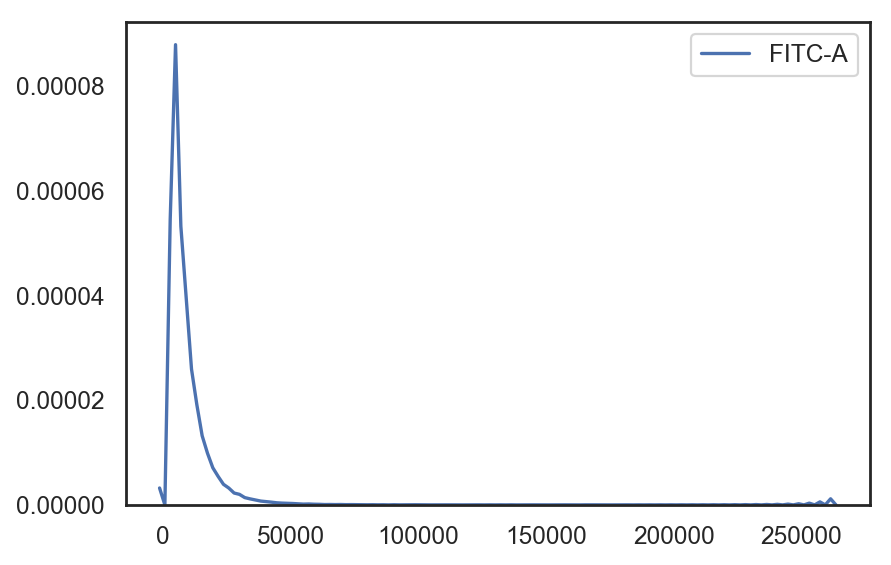

In [41]:
sns.kdeplot(df[df.AHL==1e-4]['FITC-A'])

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


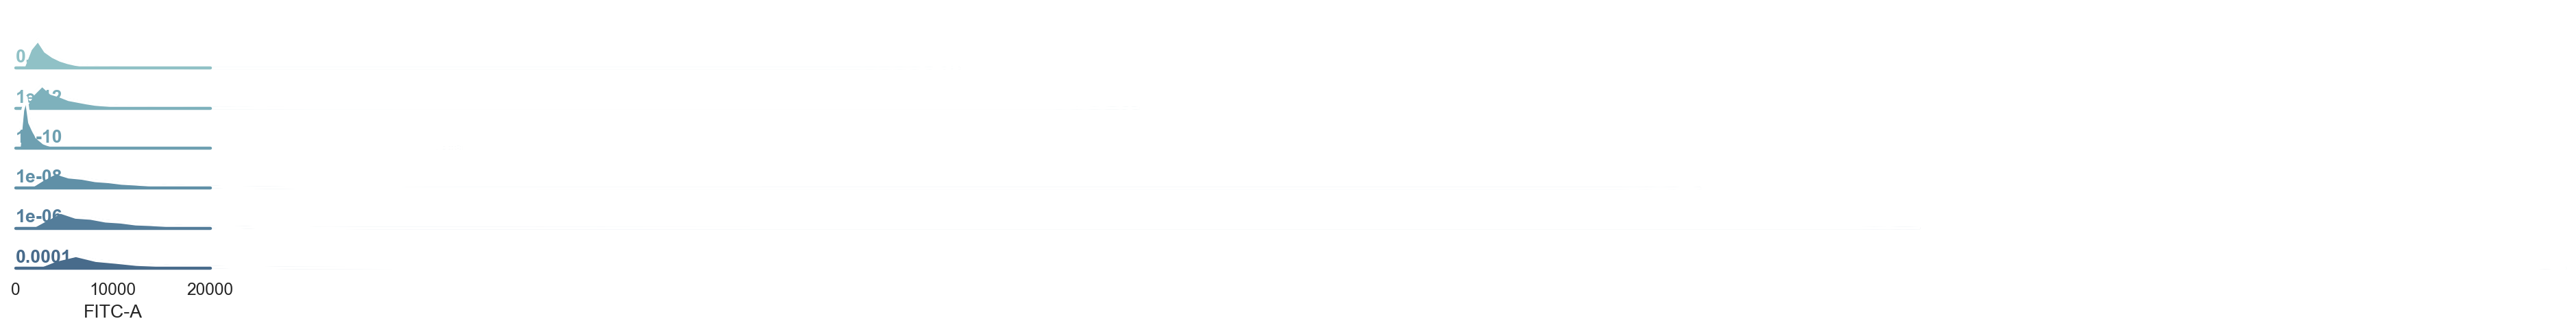

In [42]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
#rs = np.random.RandomState(1979)
#x = rs.randn(500)
#g = np.tile(list("ABCDEFGHIJ"), 50)
#df = pd.DataFrame(dict(x=x, g=g))
#m = df.g.map(ord)
#df["x"] += m
tmpdf = df[df.IPTG==0][['AHL','FITC-A']]
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=5, height=0.5, palette=pal)
g.set(xlim=(0, 20000))
# Draw the densities in a few steps
g.map(sns.kdeplot, "FITC-A", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "FITC-A", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "FITC-A")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

